In [1]:
# Alberto Bejarano (2025)
# openFDA_UMAP_v06
# pip install nbqa flake8
# nbqa flake8 openFDA_UMAP_v06.ipynb --select=F401

In [2]:
# This Jupyter notebook processes FDA adverse event data for a set of antibody-drug conjugates (ADCs). It first retrieves data using an API and extracts relevant
# details about the types of adverse events for each drug. The data is then aggregated, grouped by drug and event, and pivoted into a table format for further analysis.
# The notebook applies data scaling and dimensionality reduction techniques, such as Principal Component Analysis (PCA), to standardize and reduce the dimensionality 
# of the dataset. It uses clustering (Leiden algorithm) to group similar data points and explores the relationships between the drugs and their adverse events.
# Finally, the notebook visualizes the results using UMAP, providing insights into the patterns and associations between ADCs and the severity of their associated adverse events.

In [3]:
import warnings
from anndata._core.aligned_df import ImplicitModificationWarning
warnings.simplefilter("ignore", ImplicitModificationWarning)

In [4]:
import time; start = time.time()
from datetime import datetime; print(datetime.now().strftime("%B %d, %Y %H:%M:%S"))

April 14, 2025 23:12:52


In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = 200
#         .         .         .         .         .         .         .         .
import requests, time, matplotlib, contextlib, os
from IPython.display import Audio, display

In [6]:
import scanpy as sc
sc.settings.seed = 42

In [7]:
drug_names       = ["Kadcyla", "Adcetris", "Polivy", "Enhertu", "Trodelvy"]
adv_event_filter = ['Febrile neutropenia', 'Diarrhoea', 'Myelosuppression', 'Myalgia']

In [8]:
drug_names = ["Kadcyla", "Adcetris", "Polivy", "Enhertu", "Trodelvy",
    "Gemtuzumab ozogamicin", "Brentuximab vedotin", "Ado-trastuzumab emtansine", "Inotuzumab ozogamicin", "Moxetumomab pasudotox", "Polatuzumab vedotin",
    "Enfortumab vedotin", "Trastuzumab deruxtecan", "Sacituzumab govitecan", "Belantamab mafodotin", "Loncastuximab tesirine", "Tisotumab vedotin", "Mirvetuximab soravtansine",
    "Datroway", "BNT323/DB-1303", "BNT323", "B-1303", "ZL-1310", "IMGN853", "ABBV-181", "MCLA-128", "SYD985", "BTK-ADC", "STRO-002", "ENHERTU (DS-8201)",
    "DS-8201", "ENHERTU", "YTX-7739", "Q2W-ADC"]

In [9]:
url = "https://api.fda.gov/drug/event.json"

In [10]:
total_records = 10000
batch_size    = 1000

In [11]:
def safe_request(url, params, retries=3, delay=5):
    for i in range(retries):
        try:
            response = requests.get(url, params=params, timeout=30)
            
            if not response or response.status_code != 200:
                #print(f"Request failed with status code {response.status_code} for batch {params.get('skip', '?')}")
                continue
            return response
            
        except requests.exceptions.ReadTimeout:
            #print(f"Timeout on batch {params.get('skip', '?')} for drug {params['search']}. Retrying ({i+1}/{retries})...")
            time.sleep(delay)
            
        except requests.exceptions.RequestException as e:
            #print(f"Request failed: {e}")
            break
            
    return None  # All retries failed

In [12]:
all_records = []

In [13]:
for drug_name in tqdm(drug_names):
    for skip in range(0, total_records, batch_size):
        params = {"search": f"patient.drug.medicinalproduct:{drug_name}", "limit": batch_size, "skip": skip}
        response = safe_request(url, params)
        
        if not response:
            continue  # Skip failed attempt

        # Debugging: Check if the response has data
        #print(f"Fetched {len(response.json().get('results', []))} records for drug {drug_name}, skip {skip}.")

        data = response.json(); results = data.get("results", [])
        
        if not results:
            print(f"No data returned for batch {skip}.")
            continue  # Skip if no results
        
        for result in results:
            
            seriousness = {
                "Death":           int(result.get("seriousnessdeath", 0)),
                "Hospitalization": int(result.get("seriousnesshospitalization", 0)),
                "LifeThreatening": int(result.get("seriousnesslifethreatening", 0)),
                "Other":           int(result.get("seriousnessother", 0))}
            
            for reaction in result.get("patient", {}).get("reaction", []):
                record = {"Drug_Name": drug_name, "Adverse_Event": reaction.get("reactionmeddrapt", "Unknown"), **seriousness}
                all_records.append(record)

  0%|          | 0/34 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame(all_records)
print(len(df)); df.sample(3)

508701


,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other
61053,Enhertu,Intentional product use issue,2,2,2,1
102526,Brentuximab vedotin,Blindness,0,0,1,0
88468,Gemtuzumab ozogamicin,FEBRILE NEUTROPENIA,1,0,1,0


In [15]:
df['Drug_Name']     = df['Drug_Name'].str.title()
df['Adverse_Event'] = df['Adverse_Event'].str.title()
print(len(df)); df.sample(3)

508701


,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other
109991,Brentuximab Vedotin,Off Label Use,0,0,1,1
56442,Enhertu,Enteritis,2,1,2,1
36379,Adcetris,Eosinophilia,2,1,2,1


In [16]:
drug_names_list = df['Drug_Name'].unique().tolist()

list2_set = set(drug_names_list)
diff = [item for item in drug_names if item not in list2_set]

#print(len(drug_names)); print('\033[32m', sorted(drug_names), '\033[0m')
#print(len(diff)); print('\033[32m', sorted(diff), '\033[0m')

drug_names_word_list1 = ", ".join(sorted(drug_names));       print('\n\033[32m', drug_names_word_list1, '\033[0m')
drug_names_word_list2 = ", ".join(sorted(drug_names_list));  print('\n\033[32m', drug_names_word_list2, '\033[0m')
diff_word_list       = ", ".join(sorted(diff));              print('\n\033[32m', diff_word_list, '\033[0m\n')


 ABBV-181, Adcetris, Ado-trastuzumab emtansine, B-1303, BNT323, BNT323/DB-1303, BTK-ADC, Belantamab mafodotin, Brentuximab vedotin, DS-8201, Datroway, ENHERTU, ENHERTU (DS-8201), Enfortumab vedotin, Enhertu, Gemtuzumab ozogamicin, IMGN853, Inotuzumab ozogamicin, Kadcyla, Loncastuximab tesirine, MCLA-128, Mirvetuximab soravtansine, Moxetumomab pasudotox, Polatuzumab vedotin, Polivy, Q2W-ADC, STRO-002, SYD985, Sacituzumab govitecan, Tisotumab vedotin, Trastuzumab deruxtecan, Trodelvy, YTX-7739, ZL-1310 

 Abbv-181, Adcetris, Ado-Trastuzumab Emtansine, B-1303, Belantamab Mafodotin, Brentuximab Vedotin, Btk-Adc, Ds-8201, Enfortumab Vedotin, Enhertu, Enhertu (Ds-8201), Gemtuzumab Ozogamicin, Inotuzumab Ozogamicin, Kadcyla, Loncastuximab Tesirine, Mcla-128, Mirvetuximab Soravtansine, Moxetumomab Pasudotox, Polatuzumab Vedotin, Polivy, Q2W-Adc, Sacituzumab Govitecan, Stro-002, Syd985, Tisotumab Vedotin, Trastuzumab Deruxtecan, Trodelvy, Zl-1310 

 ABBV-181, Ado-trastuzumab emtansine, BNT323,

In [17]:
adverse_event_list = df['Adverse_Event'].unique().tolist()

print(len(adverse_event_list))
print('\n\033[32m', sorted(adverse_event_list[:10]), '\033[0m\n')

7498

 ['Anaemia', 'Cardiotoxicity', 'Cerebral Haemorrhage', 'Delirium', 'Eastern Cooperative Oncology Group Performance Status Worsened', 'Febrile Neutropenia', 'General Physical Health Deterioration', 'Infusion Related Reaction', 'Malaise', 'Mental Disorder'] 



In [18]:
# Aggregate total counts for each seriousness flag by Adverse Event and ADC Name
agg = df.groupby(["Drug_Name", "Adverse_Event"]).sum(numeric_only=True)
agg["Total"] = agg.sum(axis=1)  # Compute the 'Total' column across all seriousness flags for each Adverse Event and ADC
agg_reset = agg.reset_index()  # Reset index to flatten the DataFrame (remove multi-level index)
agg_reset = agg_reset.sort_values(by='Total', ascending=False)
print(len(agg_reset));agg_reset.head(5)

41278


,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total
17939,Enhertu,Nausea,2676,2486,2914,2516,10592
17768,Enhertu,Interstitial Lung Disease,2242,2140,2568,2124,9074
34559,Sacituzumab Govitecan,Disease Progression,2196,2228,2351,1229,8004
18005,Enhertu,Off Label Use,1890,1926,2066,1832,7714
17373,Enhertu,Disease Progression,1608,1844,2178,1842,7472


In [19]:
#agg_reset = agg_reset[agg_reset['Adverse_Event'].isin(adv_event_filter)]
print(len(agg_reset));agg_reset.head(5)

41278


,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total
17939,Enhertu,Nausea,2676,2486,2914,2516,10592
17768,Enhertu,Interstitial Lung Disease,2242,2140,2568,2124,9074
34559,Sacituzumab Govitecan,Disease Progression,2196,2228,2351,1229,8004
18005,Enhertu,Off Label Use,1890,1926,2066,1832,7714
17373,Enhertu,Disease Progression,1608,1844,2178,1842,7472


In [20]:
# Normalizes the Death, Hospitalization, and LifeThreatening columns within each drug (ADC Name), ensuring their values sum to 100%.
# It groups the data by drug, calculates the total for each seriousness column, and then divides each value by its respective total, multiplying by 100 to get percentages.
# It then drops the temporary total column and fills any NaN values.

# Step 1: Group by 'ADC Name' and sum each seriousness column
agg_reset['Total_Seriousness'] = agg_reset.groupby('Drug_Name')[['Death', 'Hospitalization', 'LifeThreatening']].transform('sum').sum(axis=1)

# Step 2: Normalize each column by dividing by the sum of that column for each drug
for col in ['Death', 'Hospitalization', 'LifeThreatening']:
    agg_reset[f'%{col}'] = agg_reset[col] * 100 / agg_reset.groupby('Drug_Name')[col].transform('sum')

# Step 3: Drop the temporary 'Total Seriousness' column
agg_reset = agg_reset.drop(columns=['Total_Seriousness'])

# Fill NaN values (if any)
agg_reset = agg_reset.fillna(0)

# Print the length and preview the updated DataFrame
print(len(agg_reset))
agg_reset.head(5)

41278


,Drug_Name,Adverse_Event,Death,Hospitalization,LifeThreatening,Other,Total,%Death,%Hospitalization,%LifeThreatening
17939,Enhertu,Nausea,2676,2486,2914,2516,10592,5.33,5.19,5.17
17768,Enhertu,Interstitial Lung Disease,2242,2140,2568,2124,9074,4.46,4.47,4.55
34559,Sacituzumab Govitecan,Disease Progression,2196,2228,2351,1229,8004,8.80,9.90,8.74
18005,Enhertu,Off Label Use,1890,1926,2066,1832,7714,3.76,4.02,3.66
17373,Enhertu,Disease Progression,1608,1844,2178,1842,7472,3.20,3.85,3.86


In [21]:
with open("./data/adverse_event_list.txt", "w") as f:
    for item in adverse_event_list:
        f.write(f"{item}\n")

In [22]:
agg_reset_2 = agg_reset[['Drug_Name', 'Adverse_Event', '%Death', '%Hospitalization']]
agg_reset_2.head(3)

,Drug_Name,Adverse_Event,%Death,%Hospitalization
17939,Enhertu,Nausea,5.33,5.19
17768,Enhertu,Interstitial Lung Disease,4.46,4.47
34559,Sacituzumab Govitecan,Disease Progression,8.80,9.90


In [23]:
pivot_df = agg_reset_2.pivot_table(index='Drug_Name', columns='Adverse_Event', values='%Death', aggfunc='sum', fill_value=0)
pivot_df = pivot_df.reset_index()
print(len(pivot_df)); pivot_df.head(3)

28


Adverse_Event,Drug_Name,Abasia,Abdominal Abscess,Abdominal Adhesions,Abdominal Cavity Drainage,Abdominal Compartment Syndrome,Abdominal Discomfort,Abdominal Distension,Abdominal Hernia,Abdominal Hernia Repair,Abdominal Incarcerated Hernia,Abdominal Infection,Abdominal Injury,Abdominal Lymphadenopathy,Abdominal Mass,Abdominal Neoplasm,Abdominal Operation,Abdominal Pain,Abdominal Pain Lower,Abdominal Pain Upper,Abdominal Rebound Tenderness,Abdominal Rigidity,Abdominal Sepsis,Abdominal Symptom,Abdominal Tenderness,Abdominal Wall Abscess,Abdominal Wall Cyst,Abdominal Wall Disorder,Abdominal Wall Haematoma,Abdominal Wall Infection,Abdominal Wall Mass,Abdominal Wound Dehiscence,Abnormal Behaviour,Abnormal Clotting Factor,Abnormal Dreams,Abnormal Faeces,Abnormal Loss Of Weight,Abnormal Menstrual Clots,Abnormal Sensation In Eye,Abnormal Uterine Bleeding,Abnormal Weight Gain,Abortion,Abortion Induced,Abortion Spontaneous,Abscess,Abscess Bacterial,Abscess Drainage,Abscess Fungal,Abscess Intestinal,Abscess Jaw,Abscess Limb,Abscess Neck,Abscess Of Salivary Gland,Abscess Oral,Abulia,Acanthamoeba Infection,Acanthosis Nigricans,Acarodermatitis,Accelerated Hypertension,Accelerated Idioventricular Rhythm,Accessory Spleen,Accident,Accident At Home,Accident At Work,Accidental Death,Accidental Exposure,Accidental Exposure To Product,Accidental Exposure To Product By Child,Accidental Overdose,Accidental Underdose,Accommodation Disorder,Acetabulum Fracture,Acetylcholinesterase Deficiency,Achromobacter Infection,Acid Base Balance Abnormal,Acid-Base Balance Disorder Mixed,Acidosis,Acinetobacter Bacteraemia,Acinetobacter Infection,Acinetobacter Sepsis,Acinetobacter Test Positive,Acne,Acne Cystic,Acne Pustular,Acoustic Stimulation Tests Abnormal,Acquired Attr Amyloidosis,Acquired Diaphragmatic Eventration,Acquired Epidermolysis Bullosa,Acquired Gene Mutation,Acquired Haemophilia,Acquired Left Ventricle Outflow Tract Obstruction,Acquired Oesophageal Web,Acquired Von Willebrand^S Disease,Acral Lentiginous Melanoma,Acrochordon,Acrophobia,Actinic Elastosis,Actinic Keratosis,Actinomyces Test Positive,Activated Partial Thromboplastin Time Prolonged,...,Volvulus,Vomiting,Vomiting Projectile,Vulval Abscess,Vulval Cancer,Vulval Cancer Stage Iii,Vulval Disorder,Vulvitis,Vulvovaginal Burning Sensation,Vulvovaginal Candidiasis,Vulvovaginal Discomfort,Vulvovaginal Dryness,Vulvovaginal Erythema,Vulvovaginal Inflammation,Vulvovaginal Injury,Vulvovaginal Mycotic Infection,Vulvovaginal Pain,Vulvovaginal Pruritus,Vulvovaginal Rash,Vulvovaginal Swelling,Vulvovaginitis,Waist Circumference Increased,Waldenstrom^S Macroglobulinaemia,Walking Aid User,Walking Disability,Walking Distance Test Abnormal,Wall Motion Score Index Abnormal,Wallerian Degeneration,Wandering Pacemaker,Warm Type Haemolytic Anaemia,Water Intoxication,Water Pollution,Waxy Flexibility,Weaning Failure,Weight Abnormal,Weight Bearing Difficulty,Weight Decreased,Weight Fluctuation,Weight Gain Poor,Weight Increased,Weight Loss Poor,West Nile Viral Infection,West Nile Virus Test Positive,Wheelchair User,Wheezing,Whipple^S Disease,White Blood Cell Analysis Abnormal,White Blood Cell Count,White Blood Cell Count Abnormal,White Blood Cell Count Decreased,White Blood Cell Count Increased,White Blood Cell Disorder,White Blood Cells Urine Positive,White Coat Hypertension,White Matter Lesion,Wisdom Teeth Removal,Withdrawal Syndrome,Wolfram Syndrome,Wound,Wound Abscess,Wound Closure,Wound Complication,Wound Decomposition,Wound Dehiscence,Wound Drainage,Wound Haematoma,Wound Haemorrhage,Wound Infection,Wound Infection Bacterial,Wound Infection Fungal,Wound Infection Pseudomonas,Wound Infection Staphylococcal,Wound Secretion,Wound Sepsis,Wrist Deformity,Wrist Fracture,Wrist Surgery,Wrong Device Used,Wrong Dose,Wrong Drug Administered,Wrong Patient Received Medication,Wrong Patient Received Product,Wrong Product Administered,Wrong Product Procured,Wrong Schedule,Wrong Technique In Device Usage Process,Wrong Technique In Dru

In [24]:
# Drop 'ADC Name' for scaling and keep it for later
adc_names = pivot_df['Drug_Name']
pivot_df2  = pivot_df.drop(columns=['Drug_Name'])
print(len(pivot_df2)); pivot_df2.head(3)

28


Adverse_Event,Abasia,Abdominal Abscess,Abdominal Adhesions,Abdominal Cavity Drainage,Abdominal Compartment Syndrome,Abdominal Discomfort,Abdominal Distension,Abdominal Hernia,Abdominal Hernia Repair,Abdominal Incarcerated Hernia,Abdominal Infection,Abdominal Injury,Abdominal Lymphadenopathy,Abdominal Mass,Abdominal Neoplasm,Abdominal Operation,Abdominal Pain,Abdominal Pain Lower,Abdominal Pain Upper,Abdominal Rebound Tenderness,Abdominal Rigidity,Abdominal Sepsis,Abdominal Symptom,Abdominal Tenderness,Abdominal Wall Abscess,Abdominal Wall Cyst,Abdominal Wall Disorder,Abdominal Wall Haematoma,Abdominal Wall Infection,Abdominal Wall Mass,Abdominal Wound Dehiscence,Abnormal Behaviour,Abnormal Clotting Factor,Abnormal Dreams,Abnormal Faeces,Abnormal Loss Of Weight,Abnormal Menstrual Clots,Abnormal Sensation In Eye,Abnormal Uterine Bleeding,Abnormal Weight Gain,Abortion,Abortion Induced,Abortion Spontaneous,Abscess,Abscess Bacterial,Abscess Drainage,Abscess Fungal,Abscess Intestinal,Abscess Jaw,Abscess Limb,Abscess Neck,Abscess Of Salivary Gland,Abscess Oral,Abulia,Acanthamoeba Infection,Acanthosis Nigricans,Acarodermatitis,Accelerated Hypertension,Accelerated Idioventricular Rhythm,Accessory Spleen,Accident,Accident At Home,Accident At Work,Accidental Death,Accidental Exposure,Accidental Exposure To Product,Accidental Exposure To Product By Child,Accidental Overdose,Accidental Underdose,Accommodation Disorder,Acetabulum Fracture,Acetylcholinesterase Deficiency,Achromobacter Infection,Acid Base Balance Abnormal,Acid-Base Balance Disorder Mixed,Acidosis,Acinetobacter Bacteraemia,Acinetobacter Infection,Acinetobacter Sepsis,Acinetobacter Test Positive,Acne,Acne Cystic,Acne Pustular,Acoustic Stimulation Tests Abnormal,Acquired Attr Amyloidosis,Acquired Diaphragmatic Eventration,Acquired Epidermolysis Bullosa,Acquired Gene Mutation,Acquired Haemophilia,Acquired Left Ventricle Outflow Tract Obstruction,Acquired Oesophageal Web,Acquired Von Willebrand^S Disease,Acral Lentiginous Melanoma,Acrochordon,Acrophobia,Actinic Elastosis,Actinic Keratosis,Actinomyces Test Positive,Activated Partial Thromboplastin Time Prolonged,Activated Partial Thromboplastin Time Shortened,...,Volvulus,Vomiting,Vomiting Projectile,Vulval Abscess,Vulval Cancer,Vulval Cancer Stage Iii,Vulval Disorder,Vulvitis,Vulvovaginal Burning Sensation,Vulvovaginal Candidiasis,Vulvovaginal Discomfort,Vulvovaginal Dryness,Vulvovaginal Erythema,Vulvovaginal Inflammation,Vulvovaginal Injury,Vulvovaginal Mycotic Infection,Vulvovaginal Pain,Vulvovaginal Pruritus,Vulvovaginal Rash,Vulvovaginal Swelling,Vulvovaginitis,Waist Circumference Increased,Waldenstrom^S Macroglobulinaemia,Walking Aid User,Walking Disability,Walking Distance Test Abnormal,Wall Motion Score Index Abnormal,Wallerian Degeneration,Wandering Pacemaker,Warm Type Haemolytic Anaemia,Water Intoxication,Water Pollution,Waxy Flexibility,Weaning Failure,Weight Abnormal,Weight Bearing Difficulty,Weight Decreased,Weight Fluctuation,Weight Gain Poor,Weight Increased,Weight Loss Poor,West Nile Viral Infection,West Nile Virus Test Positive,Wheelchair User,Wheezing,Whipple^S Disease,White Blood Cell Analysis Abnormal,White Blood Cell Count,White Blood Cell Count Abnormal,White Blood Cell Count Decreased,White Blood Cell Count Increased,White Blood Cell Disorder,White Blood Cells Urine Positive,White Coat Hypertension,White Matter Lesion,Wisdom Teeth Removal,Withdrawal Syndrome,Wolfram Syndrome,Wound,Wound Abscess,Wound Closure,Wound Complication,Wound Decomposition,Wound Dehiscence,Wound Drainage,Wound Haematoma,Wound Haemorrhage,Wound Infection,Wound Infection Bacterial,Wound Infection Fungal,Wound Infection Pseudomonas,Wound Infection Staphylococcal,Wound Secretion,Wound Sepsis,Wrist Deformity,Wrist Fracture,Wrist Surgery,Wrong Device Used,Wrong Dose,Wrong Drug Administered,Wrong Patient Received Medication,Wrong Patient Received Product,Wrong Product Administered,Wrong Product Procured,Wrong Schedule,Wrong Technique In Devic

In [25]:
# Keep a numeric-only version
df_numeric       = pivot_df2.select_dtypes(include='number').copy()
df_numeric       = df_numeric.apply(pd.to_numeric, errors='coerce', downcast='float')
pivot_df.index   = pivot_df2.index.astype(str)
df_numeric.index = df_numeric.index.astype(str)
print(df_numeric.shape); print(df_numeric.max().max())

(28, 7498)
20.0


In [26]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        from anndata._core.aligned_df import ImplicitModificationWarning
        warnings.simplefilter("ignore", ImplicitModificationWarning)

        # Flatten MultiIndex if present and reset index
        df_numeric = pivot_df2.select_dtypes(include='number').copy()
        if isinstance(df_numeric.index, pd.MultiIndex):
            df_numeric = df_numeric.reset_index(drop=True)

        # Reset index on pivot_df to ensure alignment
        pivot_df = pivot_df.reset_index(drop=True)

        # Create AnnData object
        adata_temp = sc.AnnData(df_numeric)
        adata_temp.obs['Drug_Name'] = pivot_df['Drug_Name'].values
        
        # Running PCA and Leiden
        sc.pp.pca(adata_temp)
        sc.pp.neighbors(adata_temp)
        sc.tl.leiden(adata_temp, resolution=1.00, key_added="leiden_1.00", flavor="igraph", n_iterations=2, directed=False)

CPU times: total: 15.8 s
Wall time: 18.6 s


In [27]:
# Ensure that 'ADC_Name' is correctly mapped to categorical values (for discrete colors)
adata_temp.obs['Drug_Name'] = adata_temp.obs['Drug_Name'].astype('category')

In [28]:
# Define UMAP parameters for exploration
MIN_DISTS = [0.1, 1, 10, 100, 1000, 10000, 100000]               # Adjusted values for min_dist
SPREADS   = [0.1, 1, 10, 100, 1000, 10000, 100000]             # Adjusted values for spread

  0%|          | 0/49 [00:00<?, ?it/s]

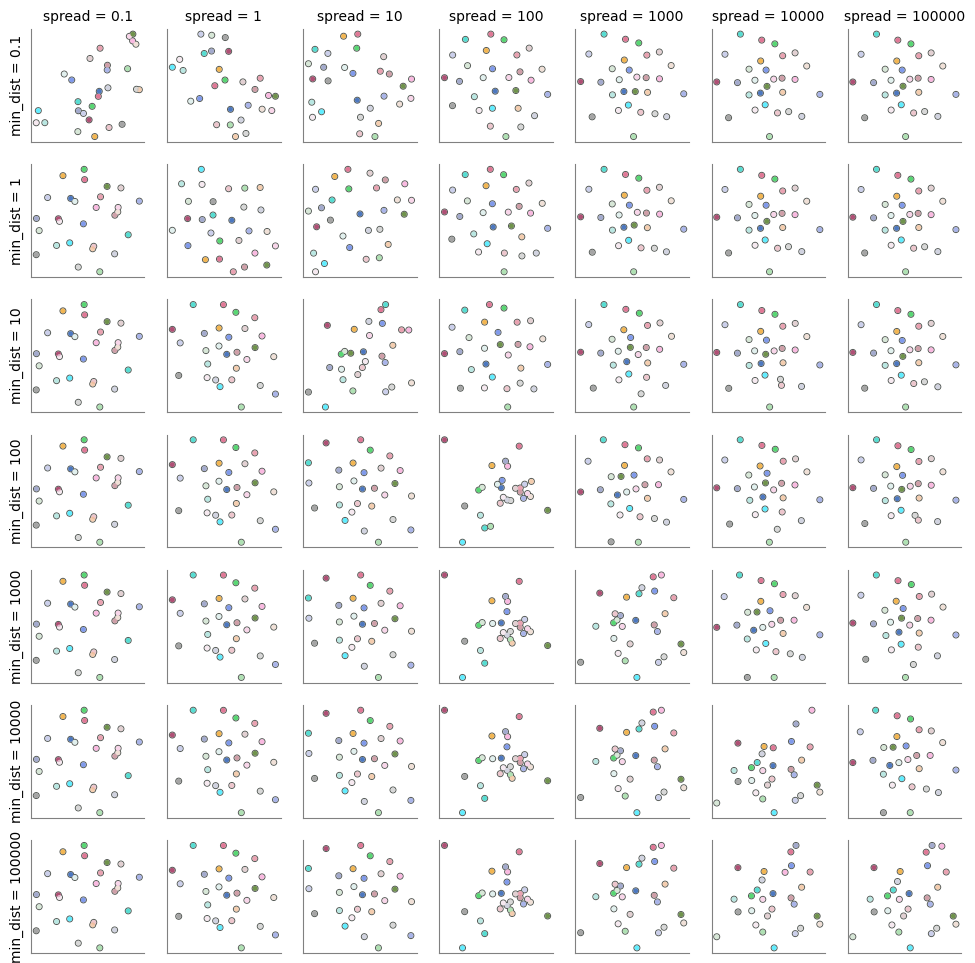

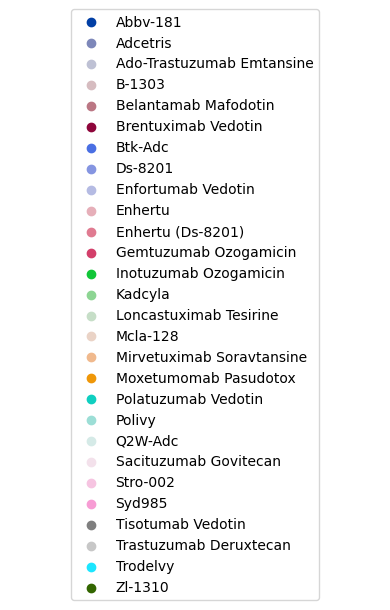

CPU times: total: 1min 39s
Wall time: 1min 41s


In [29]:
%%time
fig, axes = plt.subplots(len(MIN_DISTS), len(SPREADS), figsize=(12, 12))    # Create a figure for UMAP plots (subplots)
#          .         .          .          .          .         .          .          .          .         .          .          .
# Loop through all combinations of MIN_DIST and SPREAD
for (i, min_dist), (j, spread) in tqdm(product(enumerate(MIN_DISTS), enumerate(SPREADS)), total=len(MIN_DISTS) * len(SPREADS)):
    
    ax = axes[i][j]                                          # Get the subplot axis

    with warnings.catch_warnings():                          # Recompute UMAP with new parameters, suppressing warnings/output
        warnings.simplefilter("ignore")
        with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
    
    cmap = matplotlib.colormaps.get_cmap('tab20')             # Plot UMAP with discrete coloring
    kws = {'s': 50, 'add_outline': True, 'outline_width': (0.2, 0.01), 'outline_color': ('#545955', 'white')}
    sc.pl.umap(adata_temp, title='', color='Drug_Name', cmap=cmap, legend_loc='right margin', show=False, sort_order=False, **kws, ax=ax)

    if i == 0:                                                # Set title only for the top row
        ax.set_title(f"spread = {spread}", fontsize=10)
    else:
        ax.set_title("")                                      # Clear title if not top row

    if j == 0:                                                # Set ylabel only for the first column
        ax.set_ylabel(f"min_dist = {min_dist}", fontsize=10, rotation=90, labelpad=5)
    else:
        ax.set_ylabel("")                                     # Remove ylabel for other columns
        
    ax.set_xlabel("")
    ax.spines['top'].set_visible(False);   ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray');   ax.spines['bottom'].set_color('gray')
    
#          .         .          .          .          .         .          .          .          .         .          .          .
fig_legend, ax_legend = plt.subplots(figsize=(4, 6))          # Create an empty plot and copy the legend from the UMAP plot


handles, labels = axes[-1][-1].get_legend_handles_labels()    # Get the legend from the last UMAP plot (e.g., the last subplot)

for ax in axes.flatten():                                     # Remove the legend from the original UMAP plot
    ax.legend_.remove()

# Plot the copied legend on the empty plot
ax_legend.legend(handles, labels, loc='center')               # Plot the copied legend on the empty plot
ax_legend.axis('off')                                         # Remove axes for a clean legend-only plot
#          .         .          .          .          .         .          .          .          .         .          .          .
fig_legend.tight_layout()                                     # Save the legend-only plot
#plt.savefig("UMAP_Legend_Only.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# Adjust layout and save the UMAP figure again without the legend
#plt.tight_layout(rect=[0.01, 0.01, 0.01, 0.01])              # Leave space for Y-axis labels
#plt.savefig("UMAP_Exploration_Discrete_Colors_No_Legend.png", format="png", bbox_inches="tight", dpi=300)
plt.show(); plt.close()

In [30]:
# Set your chosen parameters
min_dist = 100     # Example, replace with your final choice
spread   = 100     # Example, replace with your final choice

# Recompute UMAP with final parameters
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, "w") as fnull, contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)

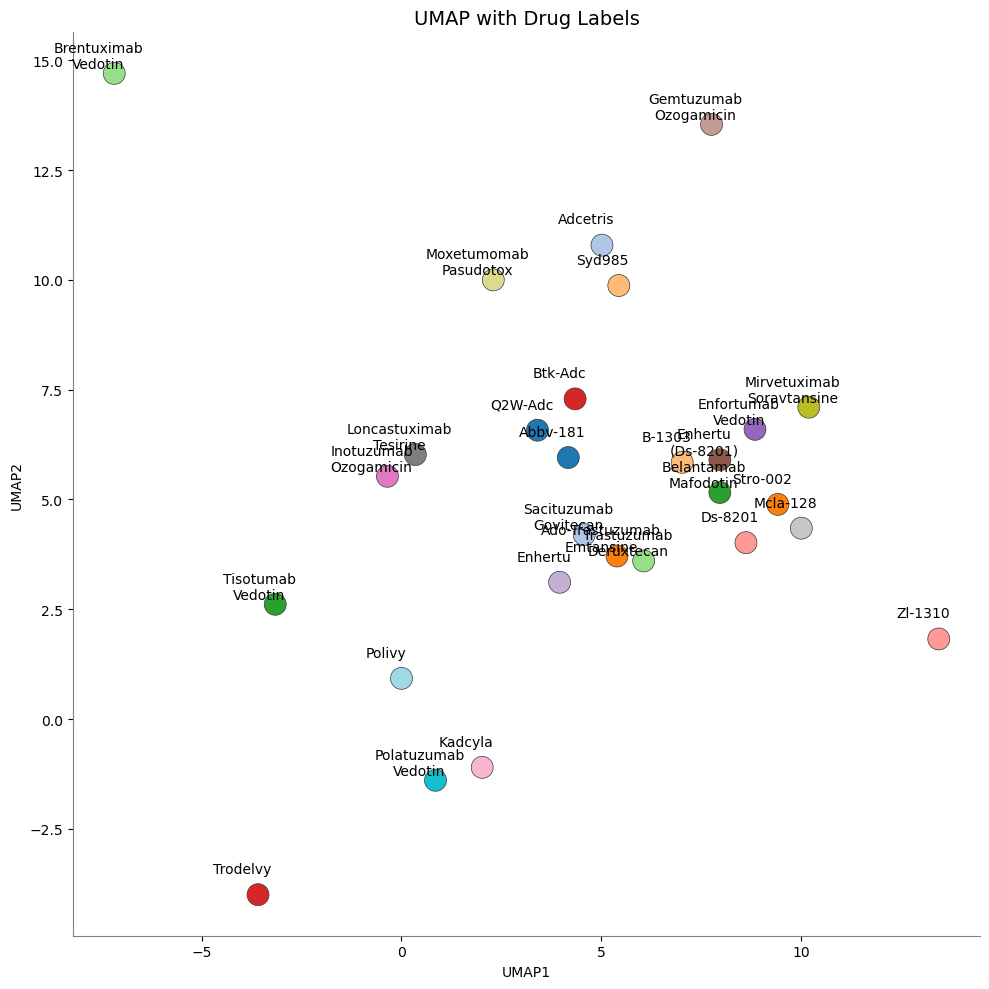

In [31]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 10))  # Big plot

# Get UMAP coordinates and labels
umap_coords = adata_temp.obsm["X_umap"]
drug_names = adata_temp.obs["Drug_Name"]

# Plot scatter manually
cmap = matplotlib.colormaps.get_cmap('tab20')
unique_drugs = drug_names.unique()
color_dict = {name: cmap(i % cmap.N) for i, name in enumerate(unique_drugs)}
colors = [color_dict[name] for name in drug_names]

ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors, s=250, edgecolor='#383838', linewidth=0.5)

# Add multi-line text labels with slight offset
for x, y, label in zip(umap_coords[:, 0], umap_coords[:, 1], drug_names):
    # Split label into multiple lines (for multi-word drug names)
    label_split = label.split(' ')
    label_top = label_split[0]  # First word
    label_bottom = ' '.join(label_split[1:])  # Remaining words
    
    # Place label a bit farther away from the dots
    ax.text(x -0.4, y + 0.4, f"{label_top}\n{label_bottom}", fontsize=10, ha='center', va='center')

# Remove axes labels
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP with Drug Labels", fontsize=14)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

plt.tight_layout()
plt.show()

In [32]:
# Path to your audio file
audio_file = "./data/clock-chime-88027.mp3"
display(Audio(audio_file, autoplay=True))

In [33]:
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print("'openFDA_UMAP_v06' script run time:", f"{int(minutes)} min {int(seconds)} sec.")

'openFDA_UMAP_v06' script run time: 29 min 35 sec.
